In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor
from sklearn.tree import DecisionTreeRegressor

import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from analysis import get_feature_importances, visualize_decision_trees, get_vif, wl_accuracy, season_record, runs_per_game

In [2]:
version = 6
df = pd.read_csv(f'./data/baseball/training/game_data_v{version}.csv')

In [3]:
# create the appropriate training and testing data based on home/away, dropping columns as needed
def create_data(drop_cols=['away_score', 'home_score', 'away_team', 'home_team'], y_col='away_score', split_by='random'):
    y = df[y_col]
    x = df.drop(drop_cols, axis=1)

    if split_by == 'season':
        x_train, x_test = x.iloc[0:13047], x.iloc[13047:]
        y_train, y_test = y.iloc[0:13047], y.iloc[13047:]
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)
    
    return x_train, x_test, y_train, y_test

In [4]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(y_col='away_score', split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(y_col='home_score', split_by='season')

In [5]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print('RANDOM FOREST REGRESSION MODEL (v2 - with increased variance)')
print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
season_record(df, results)
print('-' * 30)
runs_per_game(df, results)

RANDOM FOREST REGRESSION MODEL (v2 - with increased variance)
Accuracy: 53.37448559670782%
------------------------------
Season records:
ATL: 130-32	LAD: 120-42	TOR: 111-51	PHI: 100-62	SD: 96-66	
SF: 95-67	HOU: 94-68	MIL: 92-70	CIN: 90-72	NYM: 89-73	
TB: 89-73	MIN: 87-75	SEA: 87-75	TEX: 86-76	BOS: 84-78	
STL: 80-82	CHC: 78-84	BAL: 78-84	CLE: 76-86	MIA: 75-87	
LAA: 72-90	NYY: 70-92	AZ: 68-94	DET: 68-94	KC: 67-95	
CWS: 62-100	OAK: 54-108	WSH: 51-111	PIT: 44-118	COL: 37-125	
------------------------------
Runs scored per game:
ATL: 6.05 (979)	LAD: 5.99 (970)	MIA: 5.11 (828)	HOU: 5.02 (813)	TOR: 4.99 (809)	
MIN: 4.87 (788)	SD: 4.79 (776)	CIN: 4.79 (776)	KC: 4.71 (762)	STL: 4.68 (758)	
MIL: 4.67 (757)	NYM: 4.65 (754)	PHI: 4.61 (747)	SF: 4.6 (745)	SEA: 4.57 (741)	
DET: 4.57 (740)	TEX: 4.56 (739)	BAL: 4.54 (736)	NYY: 4.53 (734)	BOS: 4.49 (728)	
TB: 4.49 (727)	CHC: 4.42 (716)	CLE: 4.36 (707)	LAA: 4.3 (697)	AZ: 4.25 (688)	
CWS: 4.23 (686)	COL: 4.09 (662)	PIT: 4.08 (661)	OAK: 4.06 (658)	WSH: 4.

By using fewer decision trees, the aggregate records came out to be more realistic - even if it did come at the cost of losing some accuracy. Looking at the histogram below, we can see that this modified version has a mean accuracy of about 53%, which is still better than a random guessing model.

                0
count  100.000000
mean    53.020576
std      0.950299
min     50.246914
25%     52.427984
50%     52.942387
75%     53.590535
max     55.761317


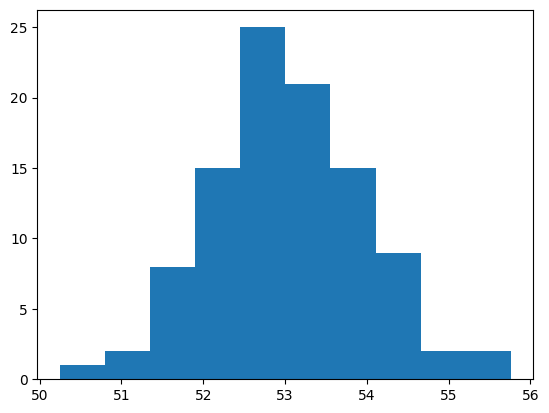

In [6]:
acc = []

for i in range(100):
    model_away.fit(x_train_away, y_train_away)
    model_home.fit(x_train_home, y_train_home)
    
    pred_away = model_away.predict(x_test_away)
    pred_home = model_home.predict(x_test_home)
    
    results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
    results.describe()
    
    acc.append(wl_accuracy(results))


print(pd.DataFrame(acc).describe())

plt.hist(acc)
plt.show()

In [ ]:
# visualize_decision_trees(model_home, x_test_home.columns)